In [14]:

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

NUMBER_OF_CLASSES=5
template_features = np.genfromtxt('../data/interim/template_matching.csv', skip_header=True, dtype=float, delimiter=',')
gabriel_features = np.genfromtxt('../data/processed/combined_features.csv', skip_header=True, dtype=float, delimiter=',')
print('labels do match?', all(template_features[:, 0] == gabriel_features[:, 0]))
y = tf.one_hot(indices=template_features[:,0], depth=NUMBER_OF_CLASSES).numpy()
X = np.hstack((template_features[:,1:], gabriel_features[:,1:]))

X = X / X.max(axis=0) # alongside rows, per column

print(X.shape, y.shape)
number_of_features = X.shape[1]

np.random.seed(42)


labels do match? True
(10000, 205) (10000, 5)


In [8]:
number_of_features

205

In [15]:


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

In [16]:


def softmax(v: np.ndarray):
    v_max = np.max(v, axis=1)[:, np.newaxis]
    exp = np.exp(v - v_max) 
    return exp / np.sum(exp, axis=1)[:, np.newaxis]


def cross_entropy(y: np.ndarray, a_o: np.ndarray):
    # numerical stability
    epsilon = 1e-12
    a_o = np.clip(a_o, epsilon, 1. - epsilon)
    return -np.mean(np.sum(y * np.log(a_o), axis=1))

def softmax_cross_entropy2deriv(y, output):
    """I'm comput dL/da * da/dz in one step in order to avoid tinkering with jacobi of softmax"""
    return (output-y)/len(y)
 
def relu(x):
    return (x>0)*x
def relu2deriv(output):
    return output > 0



In [17]:
hidden_size_1=128
hidden_size_2=128
hidden_size_3=128
output_size=5
alpha=0.1
beta=0.9

# using glorot and he initialization to omit symmetry problem
y_val_errs = []
y_train_errs = []
weights_0_1 = np.random.randn(X.shape[1], hidden_size_1) * np.sqrt(2 / X.shape[1])
weights_1_2 = np.random.randn(hidden_size_1, hidden_size_2) * np.sqrt(2 / hidden_size_1)
weights_2_3 = np.random.randn(hidden_size_2, hidden_size_3) * np.sqrt(2 / hidden_size_2)
weights_3_4 = np.random.randn(hidden_size_3, output_size) * np.sqrt(2 / (hidden_size_3+y.shape[1]))

# just constants
biases_1 = np.zeros((1, hidden_size_1))
biases_2 = np.zeros((1, hidden_size_2))
biases_3 = np.zeros((1, hidden_size_3))
biases_4 = np.zeros((1, y.shape[1]))


weights_0_1_velocity, weights_1_2_velocity, weights_2_3_velocity, weights_3_4_velocity = (0, 0, 0, 0)
biases_1_velocity, biases_2_velocity, biases_3_velocity, biases_4_velocity = (0, 0, 0, 0)
# better naming - like velocity and gradient_after_velocity

### momentum

In [5]:
for _ in range(2000):
    idx = np.random.choice(X_train.shape[0], 32, replace=False)
    labels=y_train[idx]
    layers_0 = X_train[idx]
    layers_1 = relu(layers_0 @ weights_0_1 + biases_1) 
    layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
    layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
    layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
    
    # print(cross_entropy(labels, layers_4))
    
    layers_4_delta = softmax_cross_entropy2deriv(labels, layers_4) # we combine dL/dz * dz/a
    layers_3_delta = layers_4_delta @ weights_3_4.T * relu2deriv(layers_3)
    layers_2_delta = layers_3_delta @ weights_2_3.T * relu2deriv(layers_2)
    layers_1_delta = layers_2_delta @ weights_1_2.T * relu2deriv(layers_1) 
    
    # we can add and add them.

    
    weights_3_4_velocity = beta*weights_3_4_velocity+alpha*(layers_3.T @ layers_4_delta)
    weights_2_3_velocity = beta*weights_2_3_velocity+alpha*(layers_2.T @ layers_3_delta)
    weights_1_2_velocity = beta*weights_1_2_velocity+alpha*(layers_1.T @ layers_2_delta)
    weights_0_1_velocity = beta*weights_0_1_velocity+alpha*(layers_0.T @ layers_1_delta)

    biases_4_velocity = beta*biases_4_velocity+alpha*layers_4_delta.sum(axis=0)
    biases_3_velocity = beta*biases_3_velocity+alpha*layers_3_delta.sum(axis=0)
    biases_2_velocity = beta*biases_2_velocity+alpha*layers_2_delta.sum(axis=0)
    biases_1_velocity = beta*biases_1_velocity+alpha*layers_1_delta.sum(axis=0)
    
    weights_3_4 -= weights_3_4_velocity
    weights_2_3 -= weights_2_3_velocity
    weights_1_2 -= weights_1_2_velocity
    weights_0_1 -= weights_0_1_velocity

    biases_4 -= biases_4_velocity
    biases_3 -= biases_3_velocity
    biases_2 -= biases_2_velocity
    biases_1 -= biases_1_velocity

    def pred(inputs: np.ndarray) -> np.ndarray:
        layers_1 = relu(inputs @ weights_0_1 + biases_1) 
        layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
        layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
        layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
        return layers_4
    y_val_pred = pred(X_val)
    y_train_pred = pred(X_train)
    # THIS is the exact same way that Keras default AUC (which we use in reference) is computed!
    # if y_val or layers_4 contain Nans, print them!
    y_val_err = cross_entropy(y_val, y_val_pred)
    y_train_err = cross_entropy(y_train, y_train_pred)

    y_val_errs.append(y_val_err)
    y_train_errs.append(y_train_err)

### NAG

In [18]:
for _ in range(10):
    idx = np.random.choice(X_train.shape[0], 32, replace=False)
    labels=y_train[idx]
    layers_0 = X_train[idx]
    
    velocity_factor_weights_3_4 = beta*weights_3_4_velocity
    velocity_factor_weights_2_3 = beta*weights_2_3_velocity
    velocity_factor_weights_1_2 = beta*weights_1_2_velocity
    velocity_factor_weights_0_1 = beta*weights_0_1_velocity

    velocity_factor_biases_4 = beta*biases_4_velocity
    velocity_factor_biases_3 = beta*biases_3_velocity
    velocity_factor_biases_2 = beta*biases_2_velocity
    velocity_factor_biases_1 = beta*biases_1_velocity

    weights_3_4 -= velocity_factor_weights_3_4
    weights_2_3 -= velocity_factor_weights_2_3
    weights_1_2 -= velocity_factor_weights_1_2
    weights_0_1 -= velocity_factor_weights_0_1
    
    biases_4 -= velocity_factor_biases_4
    biases_3 -= velocity_factor_biases_3
    biases_2 -= velocity_factor_biases_2
    biases_1 -= velocity_factor_biases_1

    layers_1 = relu(layers_0 @ weights_0_1 + biases_1) 
    mask_1 = np.random.randint(2, size=layers_1.shape)
    layers_1 *= mask_1 * 2
    layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
    mask_2 = np.random.randint(2, size=layers_2.shape)
    layers_2 *= mask_2 * 2
    layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
    mask_3 = np.random.randint(2, size=layers_3.shape)
    layers_3 *= mask_3 * 2
    layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
    
    # print(cross_entropy(labels, layers_4))
    
    layers_4_delta = softmax_cross_entropy2deriv(labels, layers_4) # we combine dL/dz * dz/a
    layers_3_delta = layers_4_delta @ weights_3_4.T * relu2deriv(layers_3)
    layers_3_delta *= mask_3
    layers_2_delta = layers_3_delta @ weights_2_3.T * relu2deriv(layers_2)
    layers_2_delta *= mask_2
    layers_1_delta = layers_2_delta @ weights_1_2.T * relu2deriv(layers_1) 
    layers_1_delta *= mask_1

    # we can add and add them.

    correction_factor_weights_3_4 = alpha*(layers_3.T @ layers_4_delta)
    correction_factor_weights_2_3 = alpha*(layers_2.T @ layers_3_delta)
    correction_factor_weights_1_2 = alpha*(layers_1.T @ layers_2_delta)
    correction_factor_weights_0_1 = alpha*(layers_0.T @ layers_1_delta)
    
    correction_factor_biases_4 = alpha*layers_4_delta.sum(axis=0)
    correction_factor_biases_3 = alpha*layers_3_delta.sum(axis=0)
    correction_factor_biases_2 = alpha*layers_2_delta.sum(axis=0)
    correction_factor_biases_1 = alpha*layers_1_delta.sum(axis=0)

    weights_3_4 -= correction_factor_weights_3_4
    weights_2_3 -= correction_factor_weights_2_3
    weights_1_2 -= correction_factor_weights_1_2
    weights_0_1 -= correction_factor_weights_0_1
    
    biases_4 -= correction_factor_biases_4
    biases_3 -= correction_factor_biases_3
    biases_2 -= correction_factor_biases_2
    biases_1 -= correction_factor_biases_1
    
    weights_3_4_velocity = velocity_factor_weights_3_4 + correction_factor_weights_3_4
    weights_2_3_velocity = velocity_factor_weights_2_3 + correction_factor_weights_2_3
    weights_1_2_velocity = velocity_factor_weights_1_2 + correction_factor_weights_1_2
    weights_0_1_velocity = velocity_factor_weights_0_1 + correction_factor_weights_0_1
    
    biases_4_velocity = velocity_factor_biases_4 + correction_factor_biases_4
    biases_3_velocity = velocity_factor_biases_3 + correction_factor_biases_3
    biases_2_velocity = velocity_factor_biases_2 + correction_factor_biases_2
    biases_1_velocity = velocity_factor_biases_1 + correction_factor_biases_1
    

    def pred(inputs: np.ndarray) -> np.ndarray:
        layers_1 = relu(inputs @ weights_0_1 + biases_1) 
        layers_2 = relu(layers_1 @ weights_1_2 + biases_2)
        layers_3 = relu(layers_2 @ weights_2_3 + biases_3)
        layers_4 = softmax(layers_3 @ weights_3_4 + biases_4)
        return layers_4
    y_val_pred = pred(X_val)
    y_train_pred = pred(X_train)
    # THIS is the exact same way that Keras default AUC (which we use in reference) is computed!
    # if y_val or layers_4 contain Nans, print them!
    y_val_err = cross_entropy(y_val, y_val_pred)
    y_train_err = cross_entropy(y_train, y_train_pred)

    y_val_errs.append(y_val_err)
    y_train_errs.append(y_train_err)

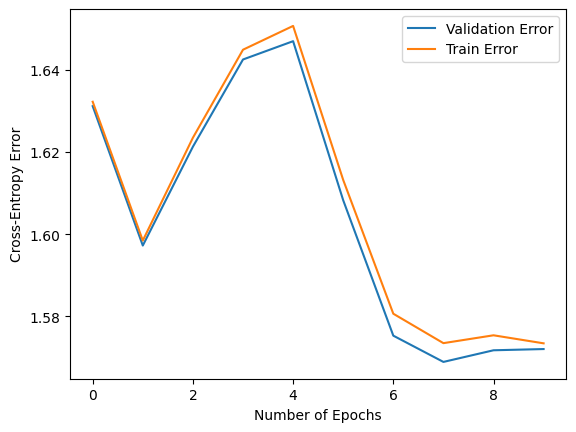

0.69290524338524

In [19]:
plt.figure()
plt.plot(y_val_errs, label='Validation Error')
plt.plot(y_train_errs, label='Train Error')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Error')
plt.legend()
plt.show()

roc_auc_score(y_val, y_val_pred, multi_class='ovr', average='macro')

### Convolution NN

In [ ]:

# Import training data

# Destructure inputs and outputs from training data
INPUTS = np.array(TRAINING_DATA["inputs"], dtype=np.float32)
OUTPUTS = np.array(TRAINING_DATA["outputs"], dtype=np.int32)

# Shuffle inputs and outputs together to improve training quality
indices = np.arange(len(INPUTS))
np.random.shuffle(indices)
INPUTS, OUTPUTS = INPUTS[indices], OUTPUTS[indices]


# Function to normalize a tensor between a specified range
def normalize(tensor, min_val, max_val):
    tensor = tf.convert_to_tensor(tensor, dtype=tf.float32)
    return (tensor - min_val) / (max_val - min_val)


# Labels for the fashion MNIST dataset
LOOKUP = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Normalize the input feature array (flattened grayscale pixel values)
INPUTS_TENSOR = normalize(INPUTS, 0, 255)

# One-hot encode the output labels for categorical cross-entropy
OUTPUTS_TENSOR = tf.one_hot(OUTPUTS, depth=10)

# Define the neural network architecture
model = tf.keras.Sequential(
    [
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),
        tf.keras.layers.Conv2D(
            16, kernel_size=3, strides=1, padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(
            32, kernel_size=3, strides=1, padding="same", activation="relu"
        ),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

# Print model architecture
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


# Train the model
def train():
    history = model.fit(
        INPUTS_TENSOR,
        OUTPUTS_TENSOR,
        validation_split=0.15,
        epochs=20,
        batch_size=256,
        shuffle=True,
    )
    return history


train()


# Function to evaluate the model using a random input sample
def evaluate():
    OFFSET = np.random.randint(0, len(INPUTS))
    input_sample = normalize(INPUTS[OFFSET], 0, 255)
    input_tensor = tf.reshape(input_sample, (1, 28, 28, 1))

    prediction = model.predict(input_tensor)
    predicted_label = np.argmax(prediction)

    print(f"Predicted: {LOOKUP[predicted_label]} | Actual: {LOOKUP[OUTPUTS[OFFSET]]}")

    return LOOKUP[predicted_label], LOOKUP[OUTPUTS[OFFSET]]


def draw_image(digit):
    import matplotlib.pyplot as plt

    image = np.reshape(digit, (28, 28)) / 255.0
    plt.imshow(image, cmap="gray")
    plt.show()


# Evaluate the model and visualize a random input sample
predicted, actual = evaluate()
print(f"Prediction: {predicted}, Actual: {actual}")
